## PimaIndiansDiabetes 데이터셋에 대한 나이브 베이즈 분류기 복습

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

In [2]:
# 데이터를 읽어들이고 고려할 특성을 선택

data = pd.read_csv('./datasets/PimaIndiansDiabetes.csv')
data_subset = data.loc[:,['Blood Glucose','BMI','Class']]

In [3]:
# 데이터 정제
bg_mask = data_subset.loc[:,'Blood Glucose']!=0
bmi_mask = data_subset.loc[:,'BMI']!=0
clean_data_subset = data_subset[bg_mask&bmi_mask]

In [4]:
# 전체 샘플 중 레이블이 1인 샘플의 비율이 0.35, 0인 샘플의 비율이 0.65

(clean_data_subset.Class == 1).sum() / len(clean_data_subset)

0.35106382978723405

In [5]:
# 테스트 데이터셋 분리(레이블의 비율을 고려하여 데이터셋 분리)

trainD, testD = train_test_split(clean_data_subset, test_size = 0.2, random_state = 20, stratify = clean_data_subset.Class)

In [6]:
(testD.Class == 1).sum() / len(testD.Class)

0.3509933774834437

In [7]:
(trainD.Class == 1).sum() / len(trainD.Class)

0.35108153078202997

In [8]:
X_train = trainD[['Blood Glucose', 'BMI']]
y_train = trainD['Class']

X_test = testD[['Blood Glucose','BMI']]
y_test = testD['Class']

## 교차검증을 이용하여 임곗값의 변화에 대해 분류기의 성능(정확도) 비교

In [9]:
# cross_val_predict를 이용하여 임곗값에 따른 정확도 비교

from sklearn.model_selection import cross_val_predict
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

classifier = GaussianNB()

In [10]:
y_val_probs = cross_val_predict(classifier, X_train,y_train,cv = 5, method = 'predict_proba')

In [11]:
y_val_probs[:3]

array([[0.49850278, 0.50149722],
       [0.67687315, 0.32312685],
       [0.07795081, 0.92204919]])

In [12]:
# 샘플이 주어질 때, 레이블이 1이 될 확률을 y_train와 같은 index순으로 구함
y_val_prob1 = y_val_probs[:,1]

In [13]:
# 0과 1을 포함하여 [0,1]을 100등분 
thresholds = np.linspace(0,1,101) #임곗값
acc = []

for t in thresholds:
    y_val_pred = y_val_prob1 >= t
    acc.append(accuracy_score(y_train,y_val_pred))
    
best_threshold = thresholds[np.argmax(acc)]

In [14]:
print(f'정확도는 임곗값이 t = {best_threshold}일 때, {acc[np.argmax(acc)]*100 : .2f}%')
print(f'임곗값이 0.5일 때 정확도는 {acc[list(thresholds).index(0.5)]*100 : .2f}%')

정확도는 임곗값이 t = 0.64일 때,  76.21%
임곗값이 0.5일 때 정확도는  74.88%


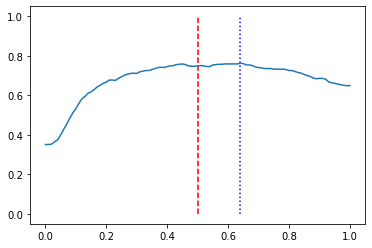

In [15]:
plt.plot(thresholds,acc)

plt.vlines(0.5, 0,1,colors = 'r',linestyles = 'dashed')
plt.vlines(0.64, 0,1,colors = 'b',linestyles = 'dotted')

## 분류기에 대한 다양한 성능 평가 1: 오차행렬

### 앞에서 교차검증 방식으로 구한 y_val_pred(예측 레이블)과 y_train(실제 레이블)으로부터 오차행렬을 구현해보자.

In [16]:
y_val_pred = (y_val_prob1 > best_threshold)

In [17]:
def my_confusion_matrix1(y_true,y_pred):
    tn = ((y_true == 0) & (y_pred == 0)).sum()
    fp = ((y_true == 0) & (y_pred == 1)).sum()
    fn = ((y_true == 1) & (y_pred == 0)).sum()
    tp = ((y_true == 1) & (y_pred == 1)).sum()
    
    return np.array([[tn,fp],[fn,tp]])

# y의 레이블 종류가 2개가 아닌 경우도 아래 코드를 조금만 수정하면 됨
def my_confusion_matrix2(y_true,y_pred):
    cf_mat = np.zeros((2,2),dtype=int)
    for i in range(2):
        for j in range(2):
            cf_mat[i,j] = ((y_true == i)&(y_pred == j)).sum()
    return cf_mat

In [18]:
my_confusion_matrix1(y_train,y_val_pred)

array([[365,  25],
       [118,  93]], dtype=int64)

In [19]:
my_confusion_matrix2(y_train,y_val_pred)

array([[365,  25],
       [118,  93]])

### `sklearn.metrics` 모듈의 `confusion_matrix` 사용

In [20]:
from sklearn.metrics import confusion_matrix

cf_matrix = confusion_matrix(y_train,y_val_pred)
cf_matrix

array([[365,  25],
       [118,  93]], dtype=int64)

## 분류기에 대한 다양한 성능 평가 2: 오차행렬의 해석

In [21]:
# 오차행렬의 해석을 위한 계산

row_sums = cf_matrix.sum(axis = 1,keepdims = True)

# cf_matrix.sum(axis = 1)와 같이 keepdims=False로 해도 아래 계산에서 broadcasting에 의해 문제 없음

norm_cf_matrix = cf_matrix / row_sums

norm_cf_matrix

array([[0.93589744, 0.06410256],
       [0.55924171, 0.44075829]])

## 분류기에 대한 다양한 성능 평가 3: 요약된 지표 - 정밀도(precision)와 재현율(recall)

### 임곗값에 따른 정밀도와 재현율의 변화를 직접 구현  

In [22]:
from sklearn.metrics import precision_score,recall_score,f1_score

Text(0.5, 0, 'threshold')

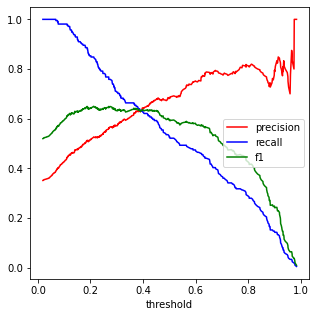

In [23]:
# 직접 구현

thresholds_1 = np.unique(y_val_prob1)
precisions_1 = []
recalls_1 = []
f1s_1 = []

for t in thresholds_1:
    y_val_pred = (y_val_prob1>=t)
    precisions_1.append(precision_score(y_train,y_val_pred))
    recalls_1.append(recall_score(y_train,y_val_pred))
    f1s_1.append(f1_score(y_train,y_val_pred))
    
plt.figure(figsize = (5,5))
plt.plot(thresholds_1,precisions_1,c='r',label='precision')
plt.plot(thresholds_1,recalls_1,c='b',label='recall')
plt.plot(thresholds_1,f1s_1,c='g',label='f1')

plt.legend(loc='center right',fontsize = 10)
plt.xlabel('threshold',fontsize=10)

In [24]:
np.argmax(thresholds_1>=0.5)

436

In [25]:
thresholds_1[np.argmax(thresholds_1>=0.5)]

0.5014972167017477

In [26]:
print(precisions_1[np.argmax(thresholds_1>=0.5)])
print(recalls_1[np.argmax(thresholds_1>=0.5)])

0.6851851851851852
0.5260663507109005


In [27]:
# 정밀도와 재현율이 같아지는 임곗값?

pr_eq_t = np.argmax(np.array(precisions_1)-np.array(recalls_1)==0)
print(thresholds_1[pr_eq_t])
print(precisions_1[pr_eq_t])
print(recalls_1[pr_eq_t])

0.3912079171353838
0.6303317535545023
0.6303317535545023


### sklearn.metrics 모듈의 precision_recall-curve를 이용하면 임곗값에 따른 정밀도와 재현율을 한꺼번에 얻을 수 있음 (API)

In [28]:
from sklearn.metrics import precision_recall_curve

precisions_2,recalls_2,thresholds_2 = precision_recall_curve(y_train,y_val_prob1)

Text(0.5, 0, 'threshold')

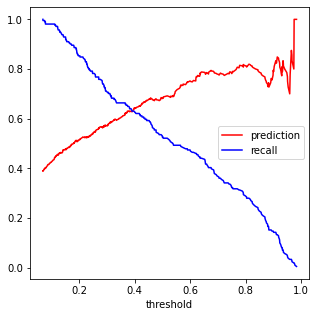

In [29]:
plt.figure(figsize = (5,5))
plt.plot(thresholds_2,precisions_2[:-1],c='r',label='prediction')
plt.plot(thresholds_2,recalls_2[:-1],c='b',label='recall')

plt.legend(loc="center right",fontsize= 10)
plt.xlabel("threshold",fontsize=10)

In [30]:
print(f'len(threshold) = {len(thresholds_2)}, len(precision) = {len(precisions_2)}, len(recall) = {len(recalls_2)}')

len(threshold) = 539, len(precision) = 540, len(recall) = 540


In [31]:
from sklearn.metrics import average_precision_score
print(f'PR곡선 아래의 넓이는 {average_precision_score(y_train,y_val_prob1) : .2f}')

PR곡선 아래의 넓이는  0.68


In [33]:
from sklearn.metrics import roc_curve, roc_auc_score

Text(0.6, 0.2, 'AUC=0.81')

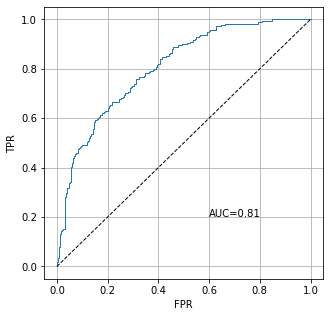

In [42]:
auc = roc_auc_score(y_train,y_val_prob1)

fpr, tpr, thresholds = roc_curve(y_train,y_val_prob1)

plt.figure(figsize = (5,5))
plt.plot(fpr,tpr,linewidth=1)
plt.plot([0,1],[0,1],'k--',linewidth=1)
plt.grid(True)
plt.xlabel("FPR",fontsize=10)
plt.ylabel("TPR",fontsize=10)
plt.text(0.6,0.2,f'AUC={auc:.2f}')